In [1]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings("ignore")

In [ ]:
import glob
import json
import pickle
import numpy as np
import proplot as pplt
import warnings
warnings.filterwarnings("ignore")

COLORS = []
colors = pplt.Cycle('ggplot')
for color in colors:
    COLORS.append(color['color'])
colors = pplt.Cycle('default')
for color in colors:
    COLORS.append(color['color'])

COLORS[0], COLORS[1] = COLORS[1], COLORS[0]

    
pplt.rc['figure.facecolor'] = 'white'

RESULT_DIR = "../../mpcd_result/"
DATA_DIR    = "../../mpcd/result_1106/"
FIGURE_DIR = "../../mpcd_figure/"

with open('plot_style.json', 'r') as f:
    format_params = json.load(f)
    
MOMENTS    = np.array([0.1, 0.08, 0.06, 0.04, 0.030, 0.024, 0.018, 0.012, 
                    0.006, 0.003, 0.001, 0.0008, 0.0006, 0.0004])

def format_ax(ax):
    ax.format(**format_params)
    ax.tick_params(top=True, right=True, bottom=True, left=True, which='both')
    ax.minorticks_on()

In [ ]:
import joblib
import shap

import matplotlib.cm as cm
import matplotlib.colors as mcolors

from MDAnalysis.lib.formats.libdcd import DCDFile

from sklearn.linear_model import Lasso
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import linregress
from tqdm import tqdm

from cg_topo_solv.analysis.conf import gyration_tensor_shape_descriptors
from cg_topo_solv.analysis.result import load_all_fit, load_target


In [8]:
hi_idx, mid_idx, lo_idx, target_curves, target_labels, target_params = load_target(RESULT_DIR, verbose=False)

all_descriptors, all_params, all_curves, shear_rates, all_graphs = load_all_fit(RESULT_DIR, rerun=False)

print(len(all_curves), len(all_descriptors), len(all_graphs))

target_indices = np.concatenate((lo_idx, mid_idx, hi_idx))
target_curves = target_curves[target_indices]
target_params = target_params[target_indices]

480 480 480


In [9]:
import os

mms = MinMaxScaler()
X = mms.fit_transform(all_descriptors)

feature_labels = [
    r"$\mathit{N}_{\mathrm{node}}$", r"$\mathit{N}_{\mathrm{edge}}$", r"$\mathit{\lambda}_{\mathrm{alg}}$", r"$\mathit{\phi}_{\mathrm{diam}}$", r"$\mathit{\phi}_{\mathrm{rad}}$",
    r"$\overline{\mathit{d}}$", r"$\overline{\mathit{d}}_{\mathrm{nb}}$", r"$\mathit{\delta}$",
    r"$\mathit{C}_{\mathrm{deg}}$", r"$\mathit{C}_{\mathrm{bet}}$", r"$\mathit{r}_{\mathrm{deg}}$", r"$\mathit{\lambda}$"
]

shap_vals_list = []
feature_vals_list = []
feature_names_list = []

alpha = 0.01

for idx_param in range(5):
    if idx_param == 2:
        y = np.log10(all_params[:, idx_param])
        idx = np.where((all_params[:, 0] - all_params[:, 1]) >= 0.0)[0]
        X_sub = X[idx]
        y = y[idx]
    else:
        y = all_params[:, idx_param]
        X_sub = X

    model = Lasso(alpha=alpha)
    model.fit(X_sub, y)

    path = os.path.join(RESULT_DIR, f'shap_values_{idx_param}_{alpha}.pickle')
    if os.path.exists(path):
        shap_values = joblib.load(path)
    else:
        explainer = shap.Explainer(model.predict, X_sub)
        shap_values = explainer(X_sub)
        joblib.dump(shap_values, path)

    mean_abs_shap = np.abs(shap_values.values).mean(axis=0)
    nonzero_idx = np.where(mean_abs_shap > 0)[0]
    top_idx = nonzero_idx[np.argsort(mean_abs_shap[nonzero_idx])[-3:][::-1]]
    shap_values_top = shap_values[:, top_idx]
    feature_names_raw = shap_values_top.feature_names
    feature_names_idx = [int(name.split(" ")[-1]) for name in feature_names_raw]
    feature_names_clean = [feature_labels[i] for i in feature_names_idx]

    shap_vals_list.append(shap_values_top.values)
    feature_vals_list.append(shap_values_top.data)
    feature_names_list.append(feature_names_clean)


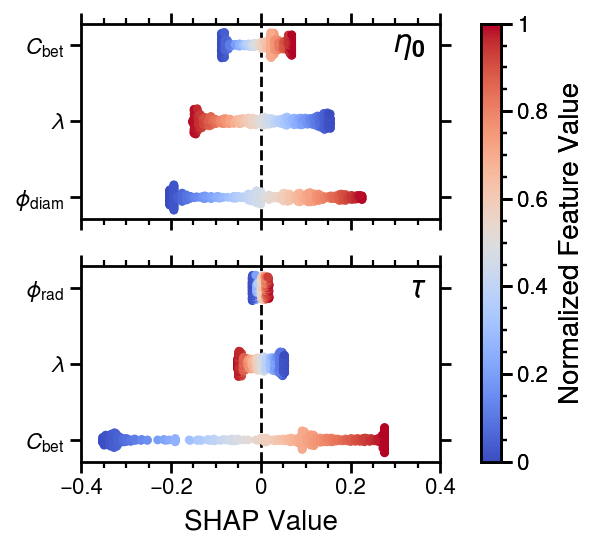

In [10]:
fig, axs = pplt.subplots(nrows=2, ncols=1, figsize=(3, 2.75))

all_vals = np.concatenate([feature_vals_list[0].ravel(), feature_vals_list[2].ravel()])
norm = mcolors.Normalize(vmin=0, vmax=1)
cmap = cm.get_cmap('coolwarm')
bin_width = 0.01
vstep = 0.05
texts = [r"$\mathit{\eta}_{0}$", r"$\mathit{\tau}$"]

for row, idx in enumerate([0, 2]):
    shap_vals = shap_vals_list[idx]
    feature_vals = feature_vals_list[idx]
    feature_names = feature_names_list[idx]
    n_samples, n_features = shap_vals.shape

    mean_abs_shap = np.abs(shap_vals).mean(axis=0)
    sorted_idx = np.argsort(-mean_abs_shap)  # descending

    shap_vals = shap_vals[:, sorted_idx]
    feature_vals = feature_vals[:, sorted_idx]
    feature_names = [feature_names[i] for i in sorted_idx]

    for i in range(n_features):
        x = shap_vals[:, i]
        c = feature_vals[:, i]

        bins = np.floor(x / bin_width).astype(int)
        x_spread = []
        y_spread = []
        colors = []

        for b in np.unique(bins):
            idx_bin = np.where(bins == b)[0]
            n = len(idx_bin)
            offsets = (np.arange(n) - n // 2) * vstep
            x_spread.extend(x[idx_bin])
            y_spread.extend(offsets)
            colors.extend(cmap(norm(c[idx_bin])))

        y_spread_adjust = y_spread / (max(y_spread) - min(y_spread)) / 3
        y_spread_adjust = y_spread_adjust + i
        axs[row].scatter(x_spread, y_spread_adjust, s=10, color=colors, edgecolor='none', zorder=3)

    axs[row].set_yticks(np.arange(n_features))
    axs[row].set_yticklabels(feature_names)
    axs[row].axvline(0, color='k', lw=1, linestyle="--", zorder=1)
    format_ax(axs[row])
    axs[row].tick_params(right=False, left=False, which='minor')
    axs[row].format(xlim=[-0.4, 0.4], xlabel="SHAP Value")
    axs[row].text(0.96, 0.96, texts[row], ha='right', va='top', transform=axs[row].transAxes, size=12, weight='bold')

mappable = cm.ScalarMappable(norm=norm, cmap=cmap)
cbar = fig.colorbar(mappable, label='Normalized Feature Value', loc='r', lw=1, width=0.1)
cbar_ax = cbar.ax
cbar_ax.tick_params(top=True, right=True, bottom=True, left=False, which='both')
cbar_ax.minorticks_on()
cbar_ax.yaxis.label.set_size(10)
cbar_ax.tick_params(labelsize=8)

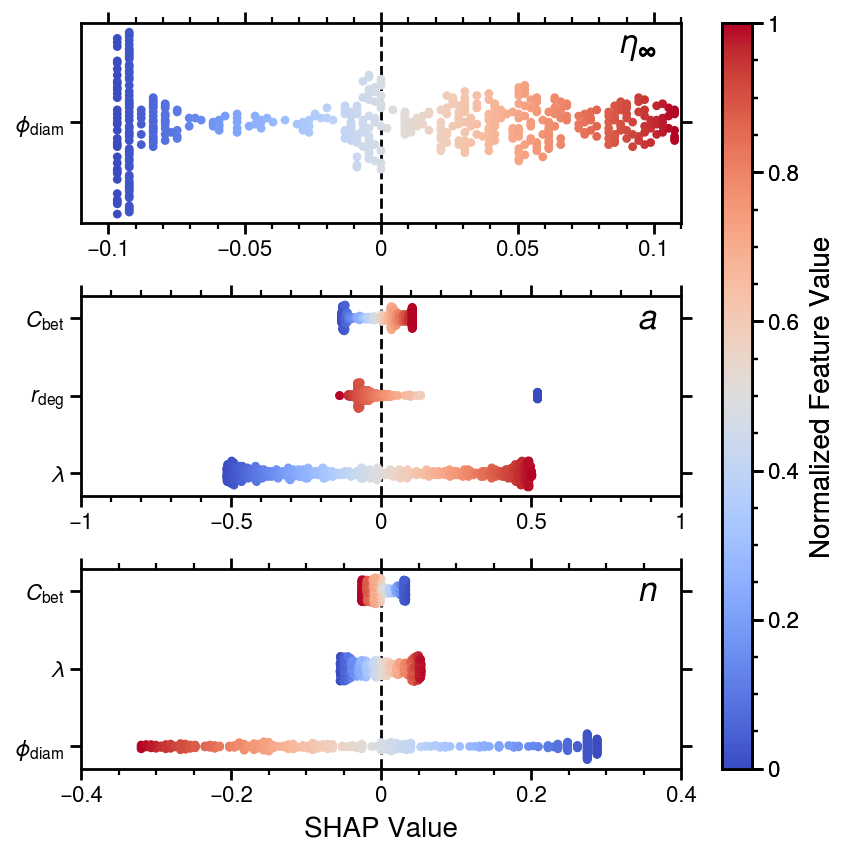

In [11]:
fig, axs = pplt.subplots(nrows=3, ncols=1, refwidth=3, refaspect=3, sharex=False)

all_vals = np.concatenate([feature_vals_list[1].ravel(), feature_vals_list[3].ravel(), feature_vals_list[4].ravel()])
norm = mcolors.Normalize(vmin=0, vmax=1)
cmap = cm.get_cmap('coolwarm')
bin_width = 0.01
vstep = 0.05
texts = [r"$\mathit{\eta}_{\infty}$", r"$\mathit{a}$", r"$\mathit{n}$"]

for row, idx in enumerate([1, 3, 4]):
    shap_vals = shap_vals_list[idx]
    feature_vals = feature_vals_list[idx]
    feature_names = feature_names_list[idx]
    n_samples, n_features = shap_vals.shape

    mean_abs_shap = np.abs(shap_vals).mean(axis=0)
    sorted_idx = np.argsort(-mean_abs_shap)  # descending

    shap_vals = shap_vals[:, sorted_idx]
    feature_vals = feature_vals[:, sorted_idx]
    feature_names = [feature_names[i] for i in sorted_idx]

    for i in range(n_features):
        x = shap_vals[:, i]
        c = feature_vals[:, i]

        bins = np.floor(x / bin_width).astype(int)
        x_spread = []
        y_spread = []
        colors = []

        for b in np.unique(bins):
            idx_bin = np.where(bins == b)[0]
            n = len(idx_bin)
            offsets = (np.arange(n) - n // 2) * vstep
            x_spread.extend(x[idx_bin])
            y_spread.extend(offsets)
            colors.extend(cmap(norm(c[idx_bin])))

        y_spread_adjust = y_spread / (max(y_spread) - min(y_spread)) / 3
        y_spread_adjust = y_spread_adjust + i
        axs[row].scatter(x_spread, y_spread_adjust, s=10, color=colors, edgecolor='none', zorder=3)

    axs[row].set_yticks(np.arange(n_features))
    axs[row].set_yticklabels(feature_names)
    axs[row].axvline(0, color='k', lw=1, linestyle="--", zorder=1)
    format_ax(axs[row])
    axs[row].tick_params(right=False, left=False, which='minor')
    axs[row].format(xlim=[-0.11, 0.11] if row == 0 else [-1, 1] if row == 1 else [-0.4, 0.4], xlabel="SHAP Value" if row == 2 else "", xticks=[-0.1, -0.05, 0, 0.05, 0.1] if row == 0 else [-1, -0.5, 0, 0.5, 1] if row == 1 else [-0.4, -0.2, 0, 0.2, 0.4])
    axs[row].text(0.96, 0.96, texts[row], ha='right', va='top', transform=axs[row].transAxes, size=12, weight='bold')

mappable = cm.ScalarMappable(norm=norm, cmap=cmap)
cbar = fig.colorbar(mappable, label='Normalized Feature Value', loc='r', lw=1, width=0.15)
cbar_ax = cbar.ax
cbar_ax.tick_params(top=True, right=True, bottom=True, left=False, which='both')
cbar_ax.minorticks_on()
cbar_ax.yaxis.label.set_size(10)
cbar_ax.tick_params(labelsize=8)

In [12]:
import os

al_paths = [
    os.path.join(RESULT_DIR, f"raw_visc_al_{i}.pickle") for i in range(1, 6)
]

with open(os.path.join(RESULT_DIR, "target_curves.pickle"), "rb") as f:
    target_data = pickle.load(f)
    target_params = target_data["params"]
    target_curves = target_data["curves"]

loaded_curves = {}
for path in tqdm(al_paths, desc="Loading pickle files"):
    with open(path, "rb") as handle:
        loaded_curves[path] = pickle.load(handle)

def extract_viscosities(paths, cached_data, target_stress=0.018, delta=0.001):
    mean_values = []
    std_values = []

    for path in tqdm(paths, desc="Processing viscosity curves"):
        records = cached_data[path]
        mean_curve = []
        std_curve = []

        for entry in records:
            stress = np.array(entry["stress"])
            mean_viscosity = np.array(entry["mean_viscosity"])
            std_viscosity = np.array(entry["std_viscosity"])
            
            idx = np.where(np.abs(stress - target_stress) < delta)[0]
            if len(idx) == 0:
                mean_curve.append(-1)
                std_curve.append(-1)
            else:
                mean_curve.append(mean_viscosity[idx[0]])
                std_curve.append(std_viscosity[idx[0]])

        mean_values.extend(mean_curve)
        std_values.extend(std_curve)

    return np.array(mean_values), np.array(std_values)

mean_viscosities, std_viscosities = extract_viscosities(al_paths, loaded_curves)

print(mean_viscosities.shape)

Processing viscosity curves: 100%|██████████| 5/5 [00:00<00:00, 2773.28it/s]

(150,)


In [14]:
for stress in ["0.0180", "0.0400"]:
    file_shape_desc = os.path.join(RESULT_DIR, f"shape_desc_al_{stress}.pickle")
    
    if os.path.exists(file_shape_desc):
        with open(file_shape_desc, "rb") as handle:
            all_shape_descriptors_list = pickle.load(handle)
    else:
        all_shape_descriptors_list = []
        
        for i in range(1, 6):
            for j in range(30):
                glob_pattern = os.path.join(
                    DATA_DIR,
                    f"batch_{i}chi",
                    "tj",
                    f"*Chi_{j}_*{stress}_9.9999*.dcd"
                )
                file = glob.glob(glob_pattern)[0]
                
                all_shape_descriptors = []
        
                with DCDFile(file) as dcd:
                    num_frames = sum(1 for _ in dcd)
                
                print(num_frames)
                
                polymer_size = int(file.split("_BATCH")[0].split("_")[-1])
                
                with DCDFile(file) as dcd:
                    for frame_idx, frame in tqdm(enumerate(dcd), total=num_frames):
                        if frame_idx >= num_frames - 500:
                            coordinates = frame.xyz
                            num_atoms = len(coordinates)
                            num_polymers = num_atoms // polymer_size
                            
                            shape_descriptors = []
                            for polymer_idx in range(num_polymers):
                                segment = coordinates[
                                    polymer_idx * polymer_size : (polymer_idx + 1) * polymer_size
                                ]
                                descriptor = gyration_tensor_shape_descriptors(segment)
                                shape_descriptors.append(descriptor)
                            all_shape_descriptors.append(shape_descriptors)
                
                all_shape_descriptors = np.array(all_shape_descriptors)
                all_shape_descriptors_list.append(all_shape_descriptors)
        
        with open(file_shape_desc, "wb") as handle:
            pickle.dump(all_shape_descriptors_list, handle)


100%|██████████| 150/150 [00:00<00:00, 227.29it/s]


(150, 10)


100%|██████████| 150/150 [00:00<00:00, 230.70it/s]


(150, 10)


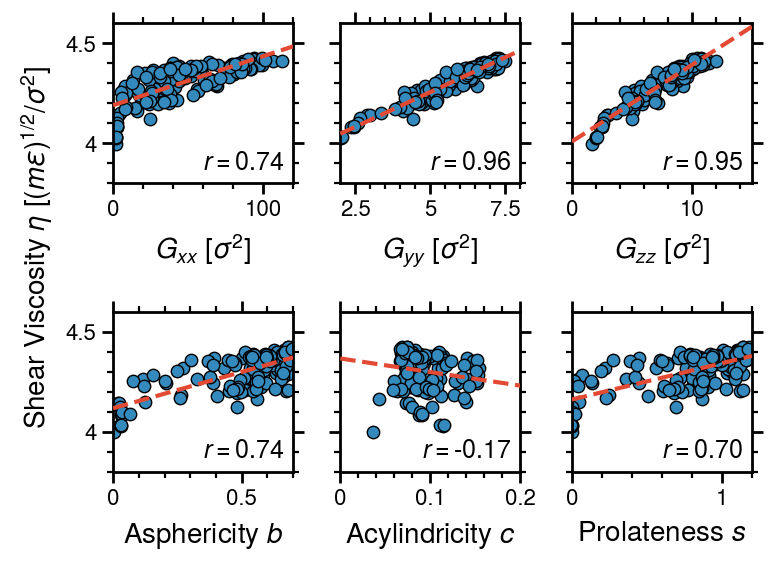

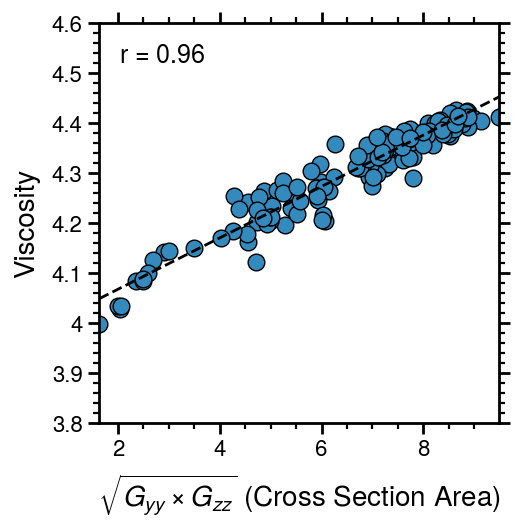

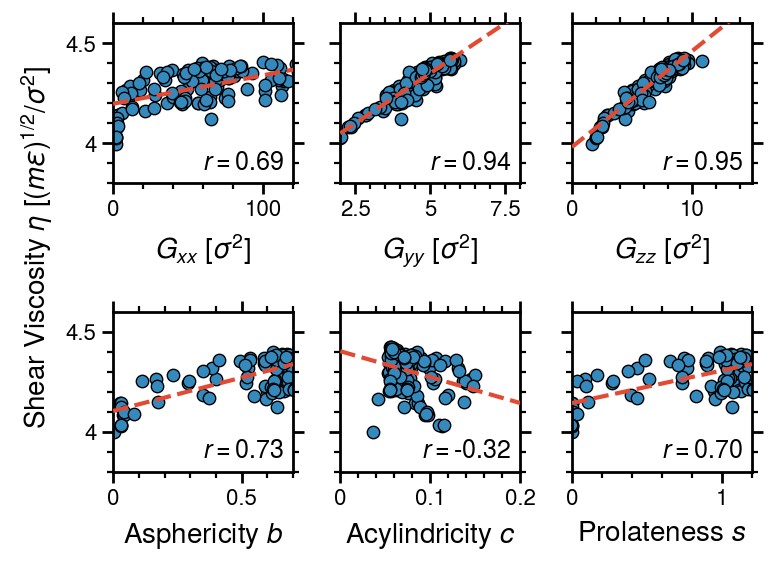

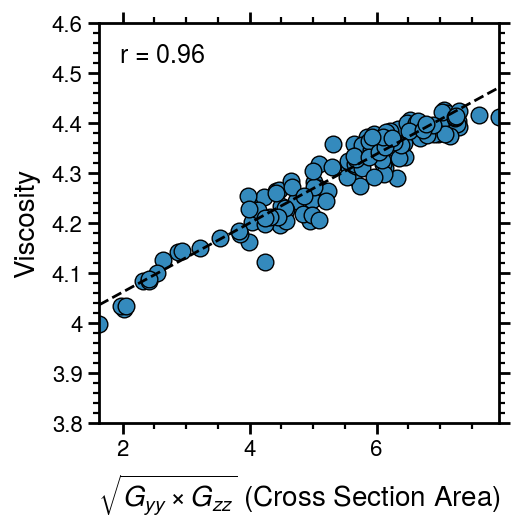

In [15]:
for stress in ["0.0180", "0.0400"]:
    file_shape_desc = os.path.join(RESULT_DIR, f"shape_desc_al_{stress}.pickle")
    
    with open(file_shape_desc, "rb") as handle:
        all_shape_descriptors_list = pickle.load(handle)
        
        mean_shape_desc = []
        for shape_desc in tqdm(all_shape_descriptors_list, total=len(all_shape_descriptors_list)):
            mean = shape_desc.mean(axis=(0, 1))
            mean_shape_desc.append(mean)
            
        mean_shape_desc = np.array(mean_shape_desc)
        print(mean_shape_desc.shape)
        
        xlabels = [
            r"$\mathit{G_{xx}}~[\mathit{\sigma}^2]$", r"$\mathit{G_{yy}}~[\mathit{\sigma}^2]$", r"$\mathit{G_{zz}}~[\mathit{\sigma}^2]$",
            r"Asphericity $\mathit{b}$", r"Acylindricity $\mathit{c}$", r"Prolateness $\mathit{s}$" 
        ]
        
        xlims = [(0, 120), (2, 8), (0, 15), (0, 0.7), (0, 0.2), (0, 1.2)]
        
        fig, axes = pplt.subplots(
            ncols=3, nrows=2, refheight=.8, refwidth=.9, sharex=False
        )
        
        descriptor_indices = [0, 1, 2, 7, 9, 8]
        
        for plot_idx, descriptor_idx in enumerate(descriptor_indices):
            x_data = mean_shape_desc[:, descriptor_idx]
            y_data = mean_viscosities
            
            axes[plot_idx].scatter(
                x_data, y_data, c=COLORS[0], edgecolor="k", lw=0.5, s=20, zorder=1
            )
        
            slope, intercept, r_value, _, _ = linregress(x_data, y_data)
            x_fit = np.linspace(xlims[plot_idx][0], xlims[plot_idx][1], 100)
            y_fit = slope * x_fit + intercept
            axes[plot_idx].plot(x_fit, y_fit, linestyle="--", color=COLORS[1], linewidth=1.5, zorder=3)
        
            axes[plot_idx].text(
                0.95, 0.05,
                r"$\mathit{r} = $"+f"{r_value:.2f}",
                transform=axes[plot_idx].transAxes,
                ha="right", va="bottom"
            )
        
            format_ax(axes[plot_idx])
            axes[plot_idx].format(
                ylabel=r'Shear Viscosity $\mathit{\eta}~[(\mathit{m}\mathit{\epsilon})^{1/2}/\mathit{\sigma}^2]$',
                xlabel=xlabels[plot_idx],
                ylim=[3.8, 4.6],
                xlim=xlims[plot_idx]
            )
        
        fig_path = os.path.join(FIGURE_DIR, f"shape_{stress}.svg")
        fig.save(fig_path, background="transparent", transparent=True, tight_layout=True)

        fig, ax = pplt.subplots(ncols=1, nrows=1, refwidth=2, refheight=2)
        
        gyy = mean_shape_desc[:, 1]
        gzz = mean_shape_desc[:, 2]
        cross_section_area = np.sqrt(gyy * gzz)
        viscosity = mean_viscosities
        
        ax.scatter(cross_section_area, viscosity, c=COLORS[0], edgecolor="k", lw=0.5)
        
        slope, intercept, r_value, _, _ = linregress(cross_section_area, viscosity)
        x_fit = np.linspace(cross_section_area.min(), cross_section_area.max(), 100)
        y_fit = slope * x_fit + intercept
        ax.plot(x_fit, y_fit, linestyle="--", color="black", linewidth=1)
        
        ax.text(
            0.05, 0.95,
            f"$r$ = {r_value:.2f}",
            transform=ax.transAxes,
            ha="left", va="top"
        )
        
        format_ax(ax)
        ax.format(
            xlabel=r"$\sqrt{\mathit{G_{yy} \times G_{zz}}}$ (Cross Section Area)",
            ylabel="Viscosity",
            ylim=[3.8, 4.6]
        )
